
## FINANCIAL ECONOMETRICS
MODULE 5 | LESSON 1

---

# **ARCH MODEL**

|  |  |
|:---|:---|
|**Reading Time** | 60 minutes |
|**Prior Knowledge** | Basics of time series, ARIMA   |
|**Keywords** | Conditional Means, Conditional Variance, Volatility Clustering, ARCH(1) Model |


---

*In the last module, we used the ARIMA model to analyze Google stock price. One key issue we observed was that Google stock price does not exhibit constant variance throughout our modeling time period. This issue does not just happen to Google's stock price. It is very common among many financial asset returns. In this module, we are going to address this phenomenon and find a model to analyze it. We will introduce the ARCH model and GARCH model to handle this issue. They are popular methods in finance to model volatility for many asset returns. In this lesson, we will start with learning the ARCH model and its properties. We will simulate the ARCH process to give a visual example and learn how to use ACF and PACF plots to identify the ARCH process.*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch.univariate import ARCH, ConstantMean, Normal
from scipy import stats

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width
# note that !pip install arch was previously run in this notebook to make the following possible

In [2]:
# Download the dataset
m5_data = pd.read_csv("M5. goog_eur_10.csv")

# Convert date variable to date format and set index
m5_data["Date2"] = pd.to_datetime(m5_data["Date"], format="%m/%d/%Y")
goog = m5_data.loc[:, ["Date2", "GOOGLE"]].set_index("Date2")

## **1. Common Features of Financial Asset Returns**

There are several special features from financial asset returns. The existence of these features motivates us to use ARCH and GARCH models to analyze financial asset returns. In this section, we are going to go through these features first so that you will have a better understanding of why we need to learn the ARCH and GARCH models. The first feature we'll talk about is the reason to use asset returns to conduct a research project instead of asset prices. 


### **1.1 Asset Return Time Series Data is More Stable Than Asset Price Time Series Data**

In a lot of financial research, we usually use asset returns instead of asset prices to conduct analysis for a financial asset. Here are some reasons to use asset returns:

> **a.** An asset return provides same-scale time series data for all financial assets. It is easier for comparison among several financial assets with different price levels. 

> **b.** Asset return time series is usually more stable than asset price time series. Let's use Google's stock price and return as an example.


**Figure 1: Google Daily Stock Price and Return Historical Chart 2016 – 2021**


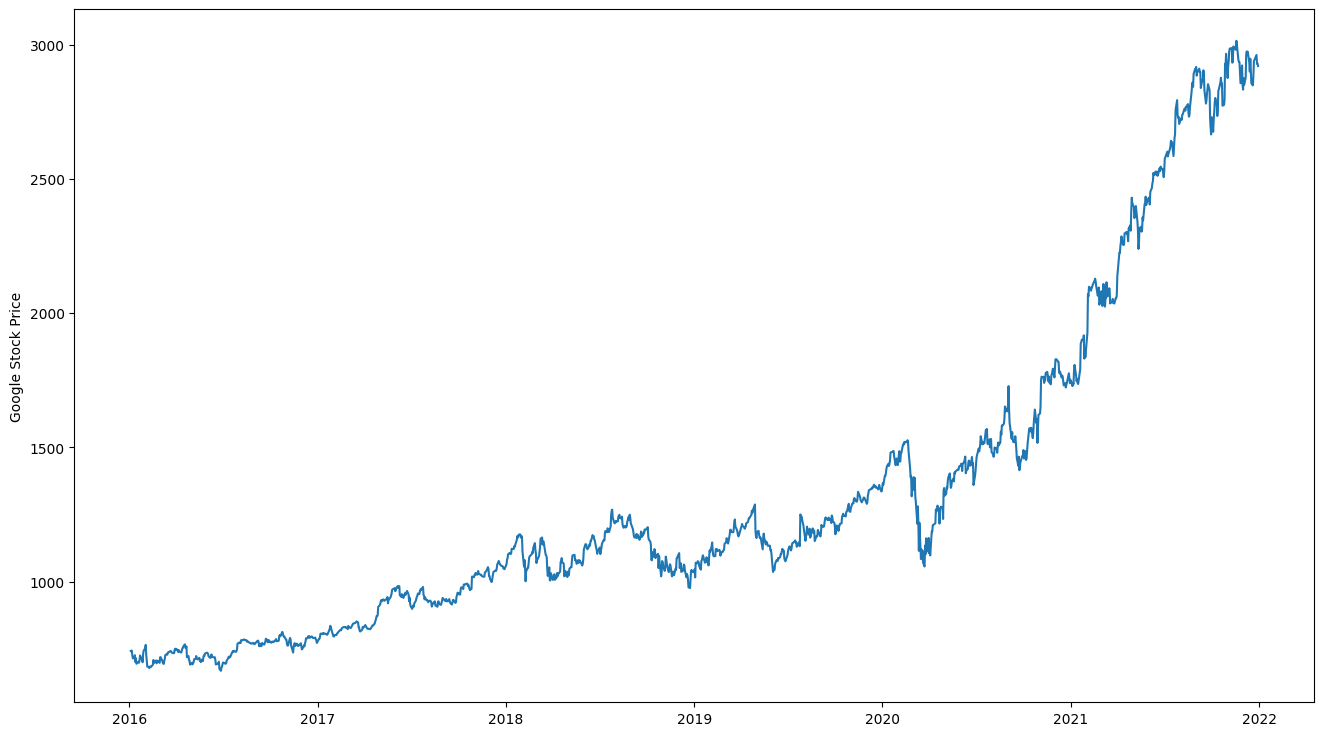

In [ ]:
# Plot Google Daily stock price and return

# Google Daily stock price
plt.plot(goog.GOOGLE)
plt.ylabel("Google Stock Price")
plt.show()

# Google Daily stock price return
goog["GOOGLE_R"] = goog.GOOGLE.pct_change()
plt.plot(goog.GOOGLE_R)
plt.ylabel("Google Stock Return")
plt.show()

In figure 1, the upper chart is Google's daily stock price chart. The bottom chart is Google's stock daily return chart. We can see that Google's price plot has an upward trend whereas Google's return plot oscillates around $0$ and is stable. We can say the return on average is $0$.

> **c.** If the asset return is small, we can approximate the return by using the difference of the natural log of price. Here is the formula:

$$ r_{t} = \frac{p_{t}-p_{t-1}}{p_{t-1}} \approx log(p_{t}) - log(p_{t-1}) $$  


### **1.2 The Volatility of Asset Returns Can Vary During Different Time Periods**

In portfolio management and risk management, managers control risk by monitoring the volatility of the underlying assets. Variance and standard deviations are common metrics to measure volatility. We can see from figure 1 that the local variance of Google stock returns changes substantially across the time period. This time series data exhibits heteroskedasticity. In the return plot, we can see there are pockets of time in the whole period where the movement of returns are more volatile than others. These high volatility pockets do not spread randomly during the whole time period. We call these **volatility clustering**. We notice that there is autocorrelation of asset returns. A highly volatile return one day would be followed by another highly volatile return the next day. It means that the past volatilities will still have an impact on today's volatility. The highly volatile periods tend to group together. This is a key property that later we would like to model. 


### **1.3 Asset Return Distribution Has Heavier Tails Than Normal Distribution**

We have discussed many times in the previous lessons that financial asset returns often show a distribution with heavier tails than normal distribution. Let's take a look at Google's stock return distribution to see if the same feature shows up. 
<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

**Figure 2: Histogram and Normal QQ Plot for Google Stock Returns**


In [ ]:
# Histogram and Normal QQ Plot for Google Stock Returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
goog_r = goog.GOOGLE_R.dropna()

# Histogram with density
x = np.linspace(min(goog_r), max(goog_r), len(goog_r))
(mu, sigma) = stats.norm.fit(goog_r)
values, bins, _ = ax1.hist(goog_r, bins=25)  # Histogram
ax1.plot(x, stats.norm.pdf(x, mu, sigma) * sum(values * np.diff(bins)), "r")  # Density
ax1.set(title="Google Stock Return Histogram")

# Normal QQ plot
sm.qqplot(goog_r, stats.norm, fit=True, line="q", ax=ax2)
ax2.set(title="Normal QQ Plot for Google Stock Return")
plt.show()

In figure 2, we show Google's stock return histogram and QQ plot. Both plots demonstrate that Google's stock return exhibits fat tail characteristic as well. 


## **2. Conditional Means and Conditional Variances**

We have talked about special features for financial asset returns time series. Before we dive into models to formally analyze those features, let's start by learning some concepts that will prepare us for explaining the models later.

We talked about conditional probability in the last module. Now let's learn how to obtain conditional means and conditional variances.

Assume $X$ and $Y$ are two discrete random variables. 

The **conditional mean** of $Y$ given $X$ is as follows:

$$ \mu_{_{Y | X}} = \sum f(Y|X) Y = E(Y|X) $$ 

where $f(Y|X)$ is the conditional probability of $Y$ given $X$.

The **conditional variance** of $Y$ given $X$ is as follows:

$$ \sigma^{2}_{_{Y|X}} = \sum Y^{2} f(Y|X) - \mu^{2}_{_{Y|X}} = E(Y^{2}|X) -  \mu^{2}_{_{Y|X}} $$

We can see that the calculation for conditional means and conditional variances are very similar to calculation for regular means and variances. The difference is we use conditional probability to calculate conditional means and conditional variances. 

Why do we need to know conditional means and conditional variances in the time series context? The central idea is how we can incorporate the concept of using past value information to predict today's value in a model. We actually did that for the ARMA model in the last module. We used the concept of conditional mean to run an ARMA model. Let's use the following example to illustrate the idea.

Consider an AR($p$) model with a constant conditional variance $Var(X_{t} | X_{t-1}, X_{t-2}, \cdots, X_{t-p}) = \sigma^{2}$. We can write the AR($p$) model as follows:

$$ X_{t} = f(X_{t-1}, X_{t-2}, \cdots, X_{t-p}) + e_{t} $$ 

where white noise $e_{t}$ has mean = $0$ and constant conditional variance $\sigma^{2}$, $\ f()$ is the conditional mean for $X_{t}$ given $X_{t-1}, X_{t-2}, \cdots, X_{t-p}$ and $\sigma^{2}$ is the constant conditional variance for $X_{t}$ given $ X_{t-1}, X_{t-2}, \cdots, X_{t-p}$.

Now if we want to introduce non-constant variance like we observed from the Google data in the last section to the above AR($p$) model, we can rewrite the model as:

$$ X_{t} = f(X_{t-1}, X_{t-2}, \cdots, X_{t-p}) + \sigma(X_{t-1}, X_{t-2}, \cdots, X_{t-p})_{t} \ e_{t} $$

Where white noise $e_{t}$ has conditional mean = $0$ and conditional variance = $1$, $\ \sigma(X_{t-1}, X_{t-2}, \cdots, X_{t-p})_{t}$ is the standard deviation for $X_{t}$ given $X_{t-1}, X_{t-2}, \cdots, X_{t-p}$. This standard deviation will change when $X_{t-1}, X_{t-2}, \cdots, X_{t-p}$ change. Since $\sigma(X_{t-1}, X_{t-2}, \cdots, X_{t-p})_{t}$ is standard deviation, it should be non-negative. Later, we will provide regularity conditions to make sure this function is non-negative.

What we just described is a general variance function model for conditional variance. ARCH and GARCH are all types of variance function models.

In the following sections, we are going to focus our analysis on asset returns. The common observation is that the conditional mean of asset return is $0$, so we will drop the conditional mean part from the above model to focus on the conditional variance part in the following sections. We will start with a simple ARCH(1) model in this lesson. Then, we will introduce a general ARCH($m$) model. In the next lesson, we will expand the ARCH model and introduce the GARCH model.


## **3. ARCH(1) Model**

Now let's formally introduce our first conditional variance model, ARCH(1) model. ARCH stands for autoregressive conditional heteroskedasticity. If we have a stationary asset return time series $r_{t}$, we can define ARCH(1) model for $r_{t}$ as follows:

$$ r_{t} = \sigma_{t} e_{t} $$

Where $e_{t} \sim iid N(0,1)$ and 

$$ \sigma^{2}_{t} = \alpha_{0} + \alpha_{1} r^{2}_{t-1} $$ 

with $\alpha_{0}>0$ and $0 \le \alpha_{1} < 1$.

The design of the above variance equation makes sure the variance is non-negative. The requirement of $\alpha_{1}\lt 1$ also ensures $r_{t}$ is stationary with finite variance. Also in many cases, instead of assuming $e_{t}$ to be standard normal distribution, we can assume $e_{t}$ follows a Student's t-distribution. Lastly, the 1 in ARCH(1) refers to the lag 1 asset return in the variance equation. 

Now let's review the properties of ARCH(1) model/process.


### **3.1 ARCH(1) is Strictly Stationary**

From $r_{t} = \sigma_{t} e_{t}$ and $\sigma^{2}_{t} = \alpha_{0} + \alpha_{1} r^{2}_{t-1}$, we know

$$ r^{2}_{t} = \alpha_{0} e_{t}^{2} + \alpha_{1} e^{2}_{t} r^{2}_{t-1} $$

By iterating the above definition, we can show that 

$$ r_{t} = e_{t} \sqrt{\alpha_{0} \Big(1 + \sum_{j=1}^{\infty } \alpha_{1}^{j} e_{t-1}^{2} \cdots e_{t-j}^{2} \Big)} $$

We will leave the proof as one open-ended question. 


### **3.2 $r_{t}$ is Conditionally Normally Distributed**

The conditional mean of $r_{t}$ is given by:

$$ E(r_{t}|r_{s}, s< t) = E(\sigma_{t}e_{t}|r_{s}, s< t) = \sigma_{t} E(e_{t}) = \sigma_{t} \cdot 0 = 0 $$

Conditional variance of $r_{t}$ is as follows:

$$ \sigma^{2}_{t} = \alpha_{0} + \alpha_{1} r^{2}_{t-1} $$

Hence $r_{t}|r_{t-1} \sim N(0, \alpha_{0} + \alpha_{1} r_{t-1}^{2})$.

We can see from the above conditional variance equation, the current variance of $r_{t}$ depends on the past value of $r_{t-1}$. It means when $r_{t-1}$ has a large value at time $t-1$, the variance at time $t$ will be large too. It then implies that $r_{t}$ will have large volatility at time $t$. This model set up is able to capture the volatility clustering phenomenon we observed in the Google stock return data.


### **3.3 $r_{t}$ is White Noise**

The unconditional mean of $r_{t}$ is as follows:

$$ E[ E(r_{t} | r_{s}, s < t)] = 0 $$

The unconditional variance of $r_{t}$ can be derived by taking the expectation of the equation from Section 3.1.

$$ \begin{align*}
  Var(r_{t}) = E(r_{t}^{2}) &= E(e_{t}^{2} (\alpha_{0} (1 + \sum_{j=1}^{\infty} \alpha_{1}^{j} e_{t-1}^{2} \cdots e_{t-j}^{2})))  \\
        &= \alpha_{0} (1 + \alpha_{1}^{1} + \alpha_{1}^{2} + \cdots + \alpha_{1}^{\infty })  \\
        &= \frac{\alpha_{0}}{1-\alpha_{1}} ,\quad \text{where }  0 \le \alpha_{1} < 1
\end{align*} $$


The autocovariance of $r_{t}$ is:

$$ \begin{align*}
  cov(r_{t+h},r_{t}) = E(r_{t+h} r_{t}) &= E[ E(r_{t+h} r_{t} | r_{s}, s\lt t+h) ] \\
        &= E[ r_{t} E(r_{t+h} | r_{s}, s\lt t+h)] \\
        &=E[ r_{t} \cdot 0] \\
        &=0 , \quad \text{ for all } h > 0
\end{align*} $$

Hence, the unconditional distribution of $r_{t}$ can be written as follows:

$$ r_{t} \sim \text{white noise} \Big(0, \frac{\alpha_{0}}{1-\alpha_{1}} \Big) $$

We can see from the above result, $r_{t}$ is unconditionally homoscedastic when $0 \le \alpha_{1} < 1$. So when $r_{t}$ is stationary ($0 \le \alpha_{1} < 1$), $\ r_{t}$ is conditionally heteroskedastic but unconditionally homoscedastic.

Although we are using asset returns for our ARCH model example, the original ARCH model was used for modeling squared error terms from a time series model. That's why the ARCH model has this nice unconditional property as white noise.


### **3.4 $r_{t}$ Is Not i.i.d.**

Although $r_{t}$ has $0$ covariance to its past values, $r^{2}_{t}$ does depend on the squared past returns. It can be shown as follows:

$$ \begin{align*}
  E(r^{2}_{t}|r_{t-1}) &= E(\alpha_{0} e_{t}^{2} + \alpha_{1} e_{t}^{2} r_{t-1}^{2} | r_{t-1})  \\
        &= \alpha_{0} + \alpha_{1} r_{t-1}^{2} 
\end{align*} $$

So we can see ARCH(1) is a case where the elements in the process have $0$ covariance, but the elements are not independent. This conclusion also confirms our previous knowledge that two variables with $0$ covariance do not mean they are independent.


### **3.5 $r_{t}^{2}$ IS A non-Gaussian AR(1) Process**

From the ARCH(1) definition, we can take the square of $r_{t}$ and rewrite the equations as follows:

$$ r_{t}^{2} = \sigma_{t}^{2} e_{t}^{2} $$

$$ \alpha_{0} + \alpha_{1} r_{t-1}^{2} = \sigma_{t}^{2} $$

We then subtract the second equation from the first equation to get the following equation:

$$ r_{t}^{2} - (\alpha_{0} + \alpha_{1} r_{t-1}^{2}) = \sigma_{t}^{2} (e_{t}^{2}-1) $$

$$ \Rightarrow r_{t}^{2} = \alpha_{0} + \alpha_{1} r_{t-1}^{2} + \nu_{t} $$

where $\nu_{t} = \sigma_{t}^{2} (e_{t}^{2} - 1)$ is non-normal white noise. $(e_t^2 – 1)$ follows a shifted Chi-Square distribution since $e_t^2$ is the square of a N(0,1) random variable.

Also if $E(r_{t}^{4}) < \infty $, then $r_{t}^{2}$ has the same ACF as AR(1) process.

The ACF for $r_{t}^{2}$ is as follows: 

$$\rho_{r^{2}}(h) = \alpha_{1}^{|h|}$$ 

for all $h$ and $\alpha_{1} < 1$.

With the knowledge that the squared asset return is also a stationary AR(1) process, we can use ACF and PACF plots of asset return and squared asset return to look for an ARCH(1) model. If the asset return time series plot exhibits a white noise pattern and the squared asset return PACF plot shows cut off pattern after lag 1, we can use an ARCH(1) model for modeling variance of the asset return. We will talk more about this in later sections.


### **3.6 $r_{t}$ Has Heavier Tails Than Standard Normal Distribution If $\alpha_{1}<\frac{1}{3}$**

When $3\alpha_{1}<1$ and $E(r_{t}^{4})<\infty $, we can show that kurtosis of $r_{t}$ is greater than 3. It means that $r_{t}$ has heavier tails than standard normal distribution. It is similar to our empirical observations that asset return usually has more outliers than a time series generated from normal distribution.

### **3.7 ARCH($m$) Process**

We have introduced ARCH(1) process in previous sections. We can extend the process to include return values from several pass time periods to form an ARCH($m$) process. An ARCH($m$) process is the process to predict current variance with squared asset return values going back to $m$ time periods. Here is the formal definition for ARCH($m$) process:

$$ r_{t} = \sigma_{t} e_{t} $$

Where $e_{t} \sim iid N(0,1)$ and

$$ \sigma^{2}_{t} = \alpha_{0} + \alpha_{1} r^{2}_{t-1} + \alpha_{2} r_{t-2}^{2} + \cdots + \alpha_{m} r_{t-m}^{2} $$

With some restrictions on ARCH($m$) coefficients, the squared asset returns will be AR($m$).


## **4. ARCH(1) Simulation**

In this section, let's take a look at simulation data to get a visual understanding of an ARCH(1) process.

**Figure 3: ARCH(1) Simulation n=1000, $\alpha_{0}=5$ and $\alpha_{1}=0.5$**


In [ ]:
# ARCH(1) Simulation n=1000, alpha_0=5 and alpha_1=0.5

# simulated process parameters
rs = np.random.RandomState([12345, 77777])
dist = Normal(seed=rs)
vol = ARCH(p=1)
repro_mod = ConstantMean(None, volatility=vol, distribution=dist)
params = pd.Series({"mu": 0.0, "omega": 5, "alpha[1]": 0.5, "beta[1]": 0.0})

# model simulation
arch1_sim = repro_mod.simulate(params, nobs=1000)
plt.plot(arch1_sim.data)
plt.show()

Figure 3 shows a simulated ARCH(1) process. From the graph, we can see the time series oscillates around $0$ with occasional bursts of volatility. We can also see there are clusters of high volatility during the whole time period, like around $t = 600$. These features are all in agreement with the common features of financial asset returns we discussed earlier.


**Figure 4: ACF and PACF of ARCH(1) Simulated Time Series**


In [ ]:
# ACF and PACF of ARCH(1) Simulated Time Series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(arch1_sim.data.dropna(), lags=20, ax=ax1)
ax1.set(title="ACF of ARCH(1) Simulated Time Series")
ax1.set_ylim([-0.2, 0.2])

sm.graphics.tsa.plot_pacf(arch1_sim.data.dropna(), lags=20, ax=ax2)
ax2.set(title="PACF of ARCH(1) Simulated Time Series")
ax2.set_ylim([-0.2, 0.2])
plt.show()

The ACF and PACF plots in figure 4 shows that the simulated time series do not exhibit any correlations and behave quite like white noise.

**Figure 5: ACF and PACF of Squared ARCH(1) Simulated Time Series**



In [ ]:
# ACF and PACF of Squared ARCH(1) Simulated Time Series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(arch1_sim.data.dropna() ** 2, lags=20, ax=ax1)
ax1.set(title="ACF of Squared ARCH(1) Simulated Time Series")
ax1.set_ylim([-0.5, 0.5])

sm.graphics.tsa.plot_pacf(arch1_sim.data.dropna() ** 2, lags=20, ax=ax2)
ax2.set(title="PACF of Squared ARCH(1) Simulated Time Series")
ax2.set_ylim([-0.5, 0.5])
plt.show()

However, in figure 5, the PACF plot of squared simulated time series shows a drop after lag 1. The ACF shows a gradual decline. The two graphs suggest the properties of the AR(1) process for the squared simulated time series.


## **5. Conclusion**

In this lesson, we went through the definition and properties of an ARCH(1) model and introduced a more general ARCH($m$) process too. In the next lesson, we will introduce another general form of the ARCH process—the GARCH process. The GARCH process is widely used in finance research. We will go through the basics and demonstrate how to apply the GARCH model to a real finance problem.


---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
